<a href="https://colab.research.google.com/github/Tubhalooter/Path-Detection-AI/blob/Mask-RCNN/Ai_1_Mask_RRCNN_Matterport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#the first notebook was to hold all of it , it has got a little messy and now i am creating a new notebook so it is a clean one. 
#this will be for training and creating and testing the model, the first one will be for cleaning and creating the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/matterport/Mask_RCNN.git
!pip3 install -r /content/Mask_RCNN/requirements.txt
!python3 /content/Mask_RCNN/setup.py install


#getting keras versions right so it works properly


!pip uninstall keras -y
!pip uninstall keras-nightly -y
!pip uninstall keras-Preprocessing -y
!pip uninstall keras-vis -y
!pip uninstall tensorflow -y
!pip uninstall h5py -y




!pip3 install tensorflow==1.15.0
!pip install keras==2.2.5
!pip install h5py==2.10.0




ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.15.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.
kapre 0.3.6 requires tensorflow>=2.0.0, but you have tensorflow 1.15.0 which is incompatible.
     |████████████████████████████████| 336 kB 5.2 MB/s 
     |████████████████████████████████| 2.9 MB 5.3 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.6.0
    Uninstalling h5py-3.6.0:
      Successfully uninstalled h5py-3.6.0


# Importing nescerry libraries and setting root Directories




In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import skimage


# Root directory of the project
ROOT_DIR = os.path.abspath("/content/Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)


Using TensorFlow backend.


... done downloading pretrained model!


# Create Config

Here i have created a config this is based off of:
https://github.com/karolmajek/Mask_RCNN/blob/master/config.py

i have not altrered much , perhaps future versions will have better fine tuned parameters that will work better

In [ ]:
class pathsConfig(Config):
  NAME ="Paths"

  GPU_COUNT=1
  IMAGES_PER_GPU=2

  NUM_CLASSES =1+1 #BACKGROUND +PATH

  # If enabled, resizes instance masks to a smaller size to reduce
  # memory load. Recommended when using high-resolution images.
  USE_MINI_MASK =True
  MINI_MASK_SHAPE=(56,56)

  IMAGE_MIN_DIM= 720
  IMAGE_MAX_DIM=1024
  IMAGE_PADDING =True

  IMAGE_META_SIZE=14
  # Image mean (RGB)
  MEAN_PIXEL = np.array([123.7, 116.8, 103.9])

  #Number of ROI's per image to feed to mask/ classifier heads
  TRAIN_ROIS_PER_IMAGE=128

  # Percent of positive ROIs used to train classifier/mask heads
  ROI_POSITIVE_RATIO = 0.33

  # Pooled ROIs
  POOL_SIZE = 7
  MASK_POOL_SIZE = 14
  MASK_SHAPE = [28, 28]

  # Maximum number of ground truth instances to use in one image
  MAX_GT_INSTANCES = 100

  # Bounding box refinement standard deviation for RPN and final detections.
  RPN_BBOX_STD_DEV = np.array([0.1, 0.1, 0.2, 0.2])
  BBOX_STD_DEV = np.array([0.1, 0.1, 0.2, 0.2])

  # Max number of final detections
  DETECTION_MAX_INSTANCES = 100

  # Minimum probability value to accept a detected instance
  # ROIs below this threshold are skipped
  DETECTION_MIN_CONFIDENCE = 0.7

  # Non-maximum suppression threshold for detection
  DETECTION_NMS_THRESHOLD = 0.3

  # Learning rate and momentum
  # The paper uses lr=0.02, but we found that to cause weights to explode often
  LEARNING_RATE = 0.002
  LEARNING_MOMENTUM = 0.9

  # Weight decay regularization
  WEIGHT_DECAY = 0.0001
      
  def __init__(self):
    """Set values of computed attributes."""
    # Effective batch size
    self.BATCH_SIZE = self.IMAGES_PER_GPU * self.GPU_COUNT

    # Input image size
    self.IMAGE_SHAPE = np.array([self.IMAGE_MAX_DIM, self.IMAGE_MAX_DIM, 3])

    # Compute backbone size from input image size
    self.BACKBONE_SHAPES = np.array(
        [[int(math.ceil(self.IMAGE_SHAPE[0] / stride)),
          int(math.ceil(self.IMAGE_SHAPE[1] / stride))]
          for stride in self.BACKBONE_STRIDES])

  def print(self):
    """Display Configuration values."""
    print("\nConfigurations:")
    for a in dir(self):
        if not a.startswith("__") and not callable(getattr(self, a)):
            print("{:30} {}".format(a, getattr(self, a)))
    print("\n")





config=pathsConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  720
IMAGE_MIN_SCALE                0
IMAGE_PADDING                  True
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mr

# DataLoader 

A dataloader was needed to load my dataset in correctly for the model to be a ble to work with, my dataset is in the COCO formt so i based my dataloader off of the dataloader for the coco sample in the matterport Mask_RCNN.

https://github.com/matterport/Mask_RCNN/blob/master/samples/coco/coco.py

for some reasons this piece of code does not work so as of now i have left the ```class_ids``` parameter to false so that this code does not run.

Code that doesnt work:
```for annotation in annotations:
            class_id = self.map_source_class_id(
                "path.{}".format(annotation['category_id']))
            if class_id:
                m = self.annToMask(annotation, image_info["height"],
                                   image_info["width"])```


In [ ]:
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
class PathDataset(utils.Dataset):
    def load_paths(self, dataset_dir, subset,class_ids=None,
                  class_map=None, return_coco=False,):
        """Load a subset of the COCO dataset.
        dataset_dir: The root directory of the COCO dataset.
        subset: What to load (train, val, minival, valminusminival)
        class_ids: If provided, only loads images that have the given classes.
        class_map: TODO: Not implemented yet. Supports maping classes from
            different datasets to the same class ID.
        return_coco: If True, returns the COCO object.
        auto_download: Automatically download and unzip MS-COCO images and annotations
        """


        pathdata = COCO((os.path.join(dataset_dir,"{}.json".format(subset))))
        if subset == "minival" or subset == "valminusminival":
            subset = "val"
        image_dir = os.path.join(dataset_dir,subset)

        # Load all classes or a subset?
        if not class_ids:
            # All classes
            class_ids = sorted(pathdata.getCatIds())
        # All images or a subset?
        if class_ids:
            image_ids = []
            for id in class_ids:
                image_ids.extend(list(pathdata.getImgIds(catIds=[id])))
            # Remove duplicates
            image_ids = list(set(image_ids))
        else:
            # All images
            image_ids = list(pathdata.imgs.keys())

        # Add classes
        for i in class_ids:
            self.add_class("path", i, pathdata.loadCats(i)[0]["name"])

        # Add images
        for i in image_ids:
            self.add_image(
                "path", image_id=i,
                path=os.path.join(image_dir, pathdata.imgs[i]['file_name']),
                width=pathdata.imgs[i]["width"],
                height=pathdata.imgs[i]["height"],
                annotations=pathdata.loadAnns(pathdata.getAnnIds(
                    imgIds=[i], catIds=class_ids, iscrowd=None)))
        if return_coco:
            return pathdata

    def load_mask(self, image_id):
        """Load instance masks for the given image.
        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        
        
        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]["annotations"]
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = self.map_source_class_id(
                "path.{}".format(annotation['category_id']))
            if class_id:
                m = self.annToMask(annotation, image_info["height"],
                                   image_info["width"])
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue
                # Is it a crowd? If so, use a negative class ID.
                if annotation['iscrowd']:
                    # Use negative class ID for crowds
                    class_id *= -1
                    # For crowd masks, annToMask() sometimes returns a mask
                    # smaller than the given dimensions. If so, resize it.
                    if m.shape[0] != image_info["height"] or m.shape[1] != image_info["width"]:
                        m = np.ones([image_info["height"], image_info["width"]], dtype=bool)
                instance_masks.append(m)
                class_ids.append(class_id)

        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2).astype(np.bool)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids
        else:
            # Call super class to return an empty mask
            return super(PathDataset, self).load_mask(image_id)

    def image_reference(self, image_id):
        """Return a link to the image in the COCO Website."""
        info = self.image_info[image_id]
        if info["source"] == "coco":
            return "http://cocodataset.org/#explore?id={}".format(info["id"])
        else:
            super(PathDataset, self).image_reference(image_id)
    
    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentation']
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle

    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m

# Create model

Here we have created our model and have set the ```mode``` to training to be used for training, we have chosen our config to be used as the ```pathsConfig()``` above, ```model_dir``` parameter states where the model will be saved


The code below is to specify what initial weights we will be loading in , this is to implememnt transfer learning with the pretrained weights as the backbones, thus we only need to train the heads of the network

In [ ]:
#created model using the confing above and will save it to the model directory specified above 
pathmodel = modellib.MaskRCNN(mode="training" , config=config , model_dir=MODEL_DIR)


#load weights to use for model

init_with ="coco"

if init_with =="imagenet":
  pathmodel.load_weights(model.get_imagenet_weights(),by_name = True)
elif init_with=="coco":
  # Load weights trained on MS COCO, but skip layers that
  # are different due to the different number of classes
  # See README for instructions to download the COCO weights

  pathmodel.load_weights(COCO_MODEL_PATH,by_name=True,exclude=["mrcnn_class_logits","mrcnn_bbox_fc","mrcnn_bbox","mrcnn_mask"])

elif init_with=="last":
  pathmodel.load_weights(model.find_last(),by_name=True)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








# Load in Data

Here we have called the PathDataset which is the dataloader that was above, we have done this for the training data and the validation data, as mentioned before the ```class_ids = False``` and we do not want to ```return_coco``` as our dataset is custom.



In [ ]:
import json
# Training dataset.
dataset_train = PathDataset()
dataset_train.load_paths("/content/drive/MyDrive/trainval","train",class_ids=False,class_map=False,return_coco=False)#class_ids left as False for now
dataset_train.prepare()

# Validation dataset
dataset_val = PathDataset()
dataset_val.load_paths("/content/drive/MyDrive/trainval","val",class_ids=False,class_map=False,return_coco=False)
dataset_val.prepare()



loading annotations into memory...
Done (t=0.39s)
creating index...
index created!
loading annotations into memory...
Done (t=0.31s)
creating index...
index created!


#Training
now we have inputted the datasets for training and validation so the network can train and the do evaluation. in this version, ```epochs=10``` and layers that are training are heads.

Note: Right now there is no implementation of fine tuning at all.

In [ ]:
# *** This training schedule is an example. Update to your needs ***
# Since we're using a very small dataset, and starting from
# COCO trained weights, we don't need to train too long. Also,
# no need to train all layers, just the heads should do it.
print("Training network heads")
pathmodel.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE, 
            epochs=10,
            layers='heads')

# Inference

we have created a new inference for our trained model to use

In [ ]:
config =pathsConfig

class inferenceConfig(config):
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1

inferconfig = inferenceConfig()

inferconfig.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  720
IMAGE_MIN_SCALE                0
IMAGE_PADDING                  True
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mr

# visualise model on val set

here we have visualised what our trained model has detected on an image from the validation set
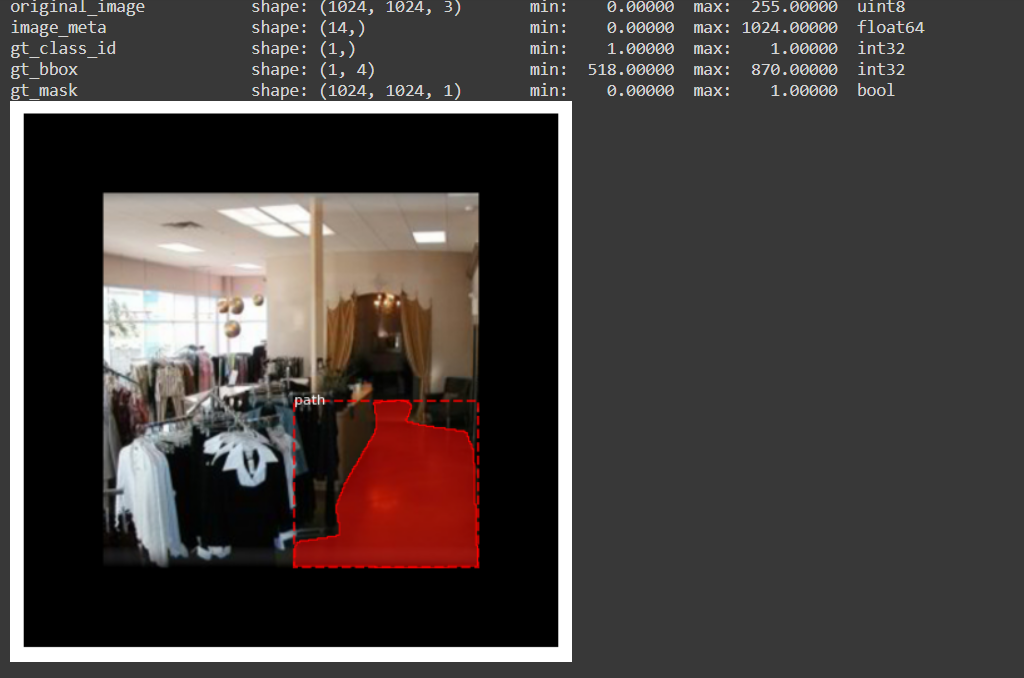


In [ ]:
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inferconfig, 
                           image_id, use_mini_mask=False)
    


log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

# Model setup

next we have created a model to be used for testing ,it is in inference mode and we have used the inferconfig defined above


we load in the weights that we trained the model on

In [ ]:
testpathmodel = modellib.MaskRCNN(mode="inference",
                                  config=inferconfig,
                                  model_dir=MODEL_DIR) # mode_dir parameter is where the model is saved


weights_path="/content/drive/MyDrive/Mask_RCNN {0}/final/{1}".format("rev1","mask_rcnn_paths_0010.h5")

print("Loading weights from {}".format(weights_path))
testpathmodel.load_weights(weights_path,by_name=True)





Instructions for updating:
Use `tf.cast` instead.
Loading weights from /content/drive/MyDrive/Mask_RCNN rev1/final/mask_rcnn_paths_0010.h5


# Testing on a provided Dataset

Here we have set the program up to pick a random image from the test directory and then we test the model on that image, for the most part it works pretty well, however sometimes it does detect paths where there isnt , for examples images of tables it happens to detect parts of the table as a path. it also does this with pools, maybe we can look into what the network is doing to improve it or maybe just a case of more data needed from a range of environments.

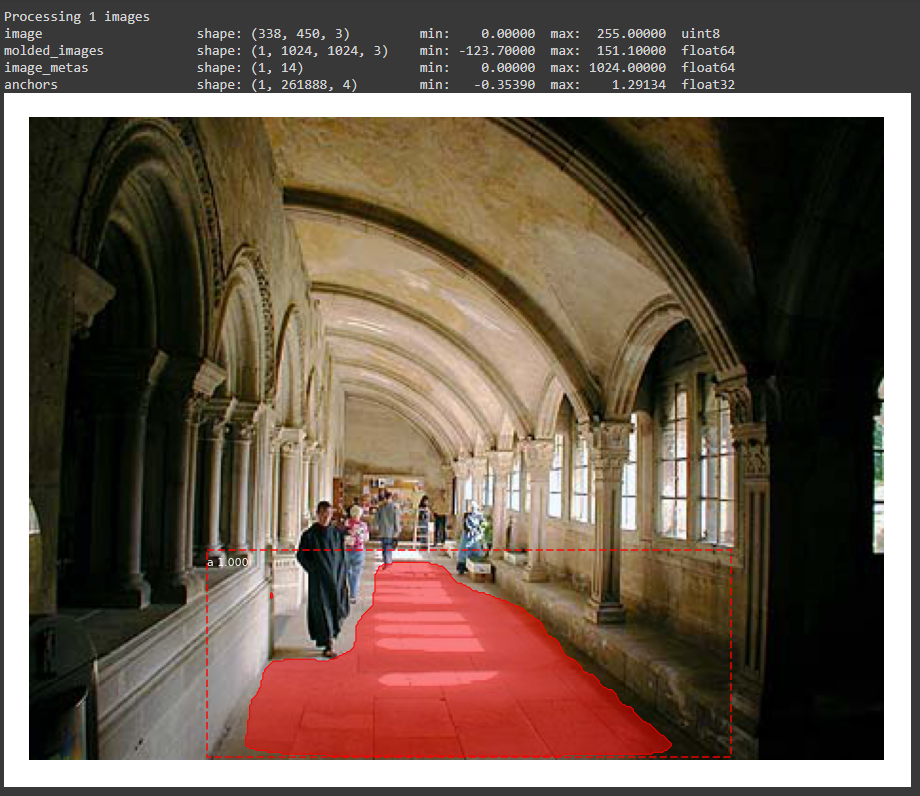

In [ ]:
testdir="/content/drive/MyDrive/separated images/testimages"
# Load a random image from test image dir
testimages = next(os.walk(testdir))[2]
rimage = skimage.io.imread(os.path.join(testdir,random.choice(testimages)))

#rimage=cv2.cvtColor(rimage,cv2.COLOR_BGR2RGB)
results=testpathmodel.detect([rimage],verbose=1)

r=results[0]
visualize.display_instances(rimage,r['rois'], r['masks'], r['class_ids'],
                            ("path"), r['scores'])



# Testing model on data that i have accumulated

here i have taken a picture on an iphone x of a corridor at college, this was in order to see how the model would fair on images that were not from the same source. this would be helpful in order to see how the model would work on data from a different camera, the data that the model was trained on was from a while ago thus the camera quality differs over time. does the model still work well on newer cameras, if so it would mean we wouldnt have to do as much preprocessing. 

Later we can feed it more data that was taken on newer cameras. This would obviously mean collecting lots of data and then annotating this data.i would think the best way to do this would be through videos and then select frames from every x amount of steps through the videos.

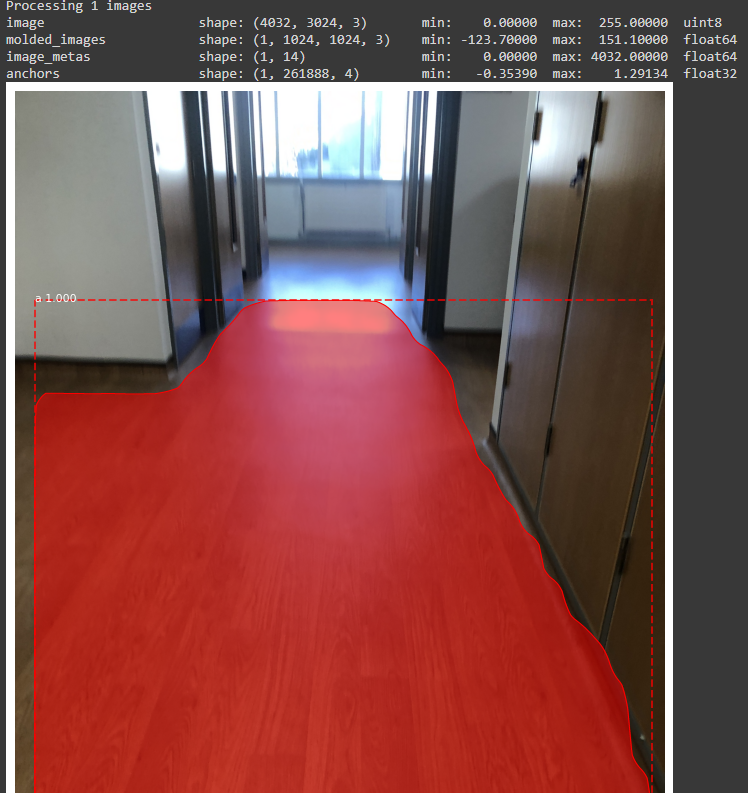

As you can see the size of the image is much much larger thann those in the dataset, such a large image is not needed as i am prettyy certain teslas cameras have a resolution of 720p this keeps the memory more efficient and also means that the model can work alot faster either we can downscale the image or even just record in 720p

In [ ]:
cimage =skimage.io.imread("/content/drive/MyDrive/IMG_0408.JPG")

#cimage=cv2.resize(cimage,(480,480))
results=testpathmodel.detect([rimage],verbose=1)

r=results[0]

visualize.display_instances(cimage,r['rois'], r['masks'], r['class_ids'],
                            ("path"), r['scores'])

# Video detection

Here we have created a custom function to display the segmentation masks, it is largely based upon the one that was made in the matterport Mask-Rcnn except it outputs an image instead which is then compiled into a video using CV2' VideoWriter() function.

when recording with my OnePlus Nord n100 , the model does not seem to detect anything, i am not sure why but perhaps it is due to different colour schemes?? 

In [ ]:
import argparse
from google.colab.patches import cv2_imshow
def my_apply_mask(image,mask,colour,alpha=0.5):
  """apply mask to image"""
  for n,c in enumerate(colour):
    image[:,:,n]= np.where(
        mask==1,
        image[:,:,n]*(1-alpha)+alpha*c,
        image[:,:,n]
    )
  return image

def my_display_instances(image,boxes,masks,class_ids,class_names,scores=None):
  assert boxes.shape[0]== masks.shape[-1]==class_ids.shape[0]

  N = boxes.shape[0]

  colours = colours=[tuple(255*np.random.rand(3))for _ in range(N)]

  for i,c in enumerate(colours):
    if not np.any(boxes[i]):
      continue

      y1,x1,y2,x2 = boxes[i]
      label=class_names[class_ids[i]]
      score =scores[i] if scores is not None else None

      mask=masks[:,:,i]
      image = my_apply_mask(image,mask,c)
      image=cv2.rectangle(image(x1,y1),(x2,y2),c,2)
      
  return image


def run_video_detect(vid_path='',save_path='',show=True):
  if vid_path == '':
    video=cv2.VideoCapture(0)
  else:
    video=cv2.VideoCapture(vid_path)
    
  if save_path=='':
    print('save path needs to be specified')
  else:
    width = int(video.get(3))
    height=int(video.get(4))
    fps=video.get(cv2.CAP_PROP_FPS)
    output=cv2.VideoWriter(save_path,cv2.VideoWriter.fourcc('M','J','P','G'),fps,(width,height))
  while video.isOpened():
    _,image=video.read()
    image=cv2.resize(image,(1280,720))
    results=testpathmodel.detect([image],verbose=1)
    r=results[0]
    image= my_display_instances(image,r['rois'],r['masks'],r['class_ids'],['path'],r['scores'])

    if show==True:
      cv2_imshow(image)

      key=cv2.waitKey(1)
      if key==27:
        break
    output.write(image)

  video.release()
  output.release()
  cv2.destroyAllWindows()


# Video detection from gilbert tanner tutorial

here is the one i used with my nord n100, it is following a tutorial from gilbert tanner only changed slightly to avoid argparse usage. 


here is an output of a single frame

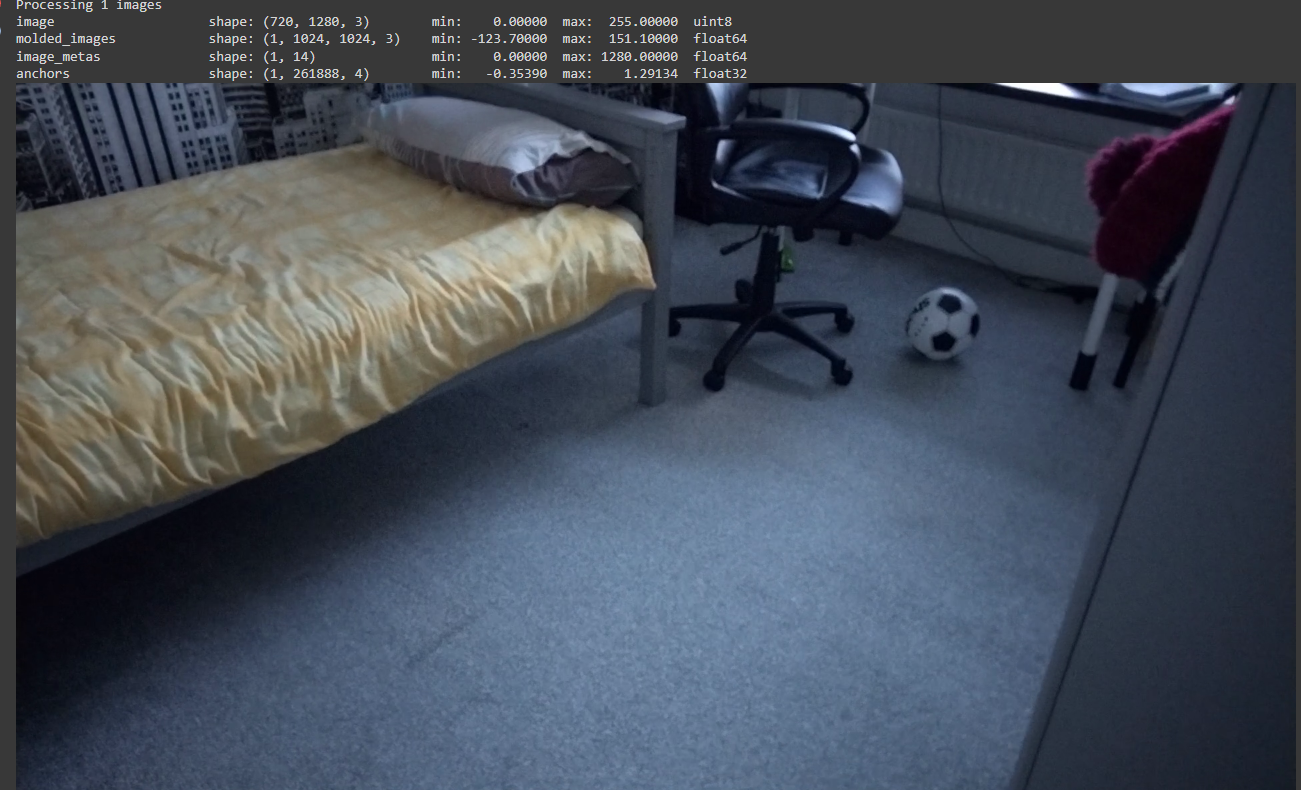

The annoying thing is that i have now realised that Mask-RCNN is real inefficient , i only found this out when trying to detect on video where the runtime kept crashing due to lack of memory , if i am correct , collab allows usage of 13gb of r thiis is clearly inefficient .perhaps a more efficient solution is to usea more simple archtechture , maybe mobilenet , unet, or squuezenet, i may  try and build the model fomy self using tf keras , i will try and make that more efiicient than the current one

In [ ]:
run_video_detect(vid_path='/content/drive/MyDrive/Path videos/standard.mp4',save_path='output.avi')

# My implementation of Video detection

Below is the code that i wrote to detect paths in videos. the video i tested this on was with an iphone x and i think the resolution was 1080p however i downscaled it to 480p it detected paths however they had like a gap/ hole in them as shown below :

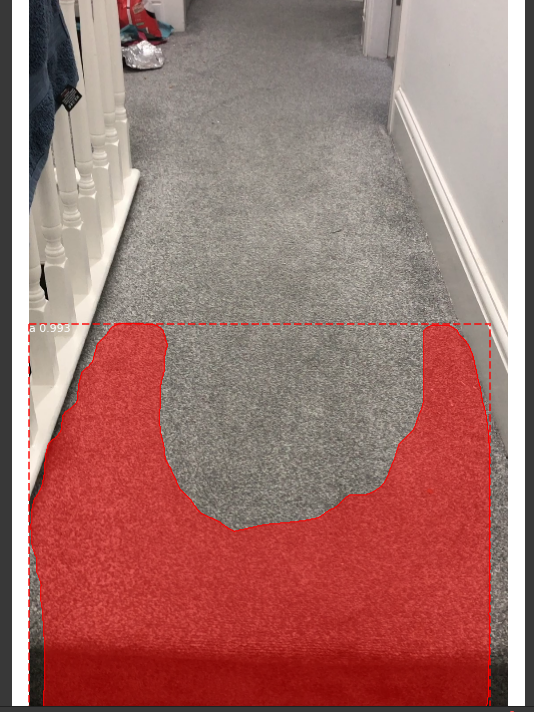

My guess would be that in the data , i went around blockages and the network has thought that there is something in the way, we can clearly see that is not the case.
This problem can probably be solved with more data or maybe even fine tuning the model.


another issue was that i was getting an error with resizing saying that a , (i think) there was nothing to resize, i dont know why this would be the case since it is a while loop with the condition that the video is still opened and if the video is finished it should not run, this is an error with code and not the model or the data. i tried to find a way around this but could not figure it out

In [ ]:
from google.colab.patches import cv2_imshow

video = cv2.VideoCapture("/content/drive/MyDrive/IMG_0417.MOV")
while (video.isOpened()):
  _,frame=video.read()
  frame=cv2.rotate(frame,cv2.cv2.ROTATE_90_CLOCKWISE)
  try:
    frame=cv2.resize(frame,(480,852))
  except:
    continue
  frame= cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
  if _ ==False:
    break

  else:
    
    results=testpathmodel.detect([frame],verbose=1)
    r=results[0]
    image = visualize.display_instances(frame,r['rois'],r['masks'],r['class_ids'],("path"),r['scores'])

    out = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc('M','J','P','G'),10,(480,852))
    out.release()
  #key = cv2.waitKey(1)
  #if key==(27):
    #break




# End

Going on from here , i may try to make a custom model, this may work better in terms of efficiency but may lack accuracy, i will try and follow an architecture of a model such as mobile net , u-net, squeeze net or any other. We will see how this works out. 

This model was trained on 300 or so images which were labelled by me manually, perhaps more data will be gathered in the future.

Thankee !